# Autoregressive Models

Ever wondered how financial analysts predict tomorrow's stock prices, how meteorologists forecast next week's weather, or how engineers anticipate system failures before they happen? Welcome to the fascinating world of **autoregressive models** – the mathematical engines that power predictions when the future depends on the past.

In this hands-on example, we'll dive into the elegant framework of Bayesian autoregressive modeling using RxInfer.jl, a powerful probabilistic programming library that makes complex inference tasks surprisingly accessible. Unlike traditional approaches that give you a single prediction, our Bayesian approach provides complete predictive distributions, capturing the uncertainty that's inherent in any real-world forecast.

You'll discover how to:
- Create and understand AR (both univariate and multivariate) and ARMA models through a Bayesian lens with RxInfer.jl and `@model` macro
- Generate synthetic data to test your inference algorithms
- Perform automated variational Bayesian inference with RxInfer.jl
- Make probabilistic predictions with quantified uncertainty
- Apply these techniques to real-world stock price data

Whether you're predicting financial markets, analyzing sensor readings, modeling climate patterns, or exploring any time-dependent phenomenon, the techniques you'll learn here provide a robust foundation for sophisticated time series analysis using autoregressive models.

## The Mathematics Behind Autoregressive Models

At their core, autoregressive (AR) models capture a fundamental principle: the future depends on the past. But how do we translate this intuition into mathematical precision? Let's build the framework together.

Imagine we're tracking a variable over time - stock prices, temperature readings, or any quantity that evolves sequentially. In an AR model, we express the current value as a function of its previous values, plus some random noise. This elegantly captures both deterministic patterns and inherent uncertainty.

In our Bayesian formulation, we model this process as:

$$\begin{aligned}
p(\gamma) &= \Gamma(\gamma|a, b),\\
p(\mathbf{\theta}) &= \mathcal{N}(\mathbf{\theta}|\mathbf{\mu}, \Sigma),\\
p(x_t|\mathbf{x}_{t-1:t-k}) &= \mathcal{N}(x_t|\mathbf{\theta}^{T}\mathbf{x}_{t-1:t-k}, \gamma^{-1}),\\
p(y_t|x_t) &= \mathcal{N}(y_t|x_t, \tau^{-1}),
\end{aligned}$$

Here's what this means in plain language:
- $x_t$ represents our system's true state at time $t$
- $\mathbf{x}_{t-1:t-k}$ captures the sequence of $k$ previous states
- $\mathbf{\theta}$ holds the "memory coefficients" - how much each past state influences the present
- $\gamma$ controls the randomness in state transitions (higher values mean less randomness)
- $y_t$ is what we actually observe, which includes some measurement noise controlled by $\tau$

The beauty of this formulation is that it handles both the "signal" (predictable patterns) and the "noise" (random fluctuations) in a principled way.

For readers interested in the deeper theoretical foundations, we recommend [Albert Podusenko's excellent work on Message Passing-Based Inference for Time-Varying Autoregressive Models](https://www.mdpi.com/1099-4300/23/6/683).

Now, let's translate this mathematical framework into code and see it in action!

In [44]:
using RxInfer, Distributions, LinearAlgebra, Plots, StableRNGs

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

## Starting Simple: From Synthetic to Real-World Data

In our code implementation, we begin by generating synthetic data using predefined sets of coefficients for autoregressive models with orders 1, 2, and 5.

Starting with synthetic data offers several advantages:
- **Ground Truth**: We know the exact coefficients that generated the data, making it possible to evaluate how well our inference algorithms recover these parameters.
- **Control**: We can test our models under different noise levels, sample sizes, and process specifications without the complexity of real-world data.
- **Learning Progression**: By beginning with synthetic examples, we can build intuition about how AR models behave before tackling the messier challenges of real data.

Later in the example, we'll transition to real-world stock price data, where the true generative process is unknown.

In [13]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

The coefficients we've selected aren't arbitrary - they're carefully chosen to ensure stability in our autoregressive processes. In signal processing and time series analysis, _stable poles_ refer to coefficients that keep the AR process from exploding or diverging over time. Mathematically, this means that the roots of the AR characteristic polynomial must lie inside the unit circle in the complex plane.
For example, in a first-order AR model where $x_t = \theta x_{t-1} + \varepsilon_t$, we need $|\theta| < 1$ to ensure stability. For higher-order models, the constraints become more complex, but the principle remains the same: without stability, our models would produce unrealistic, explosive behavior.

In [234]:
function generate_synthetic_dataset(; n, θ, γ = 1.0, τ = 1.0, rng = StableRNG(42))
    order = length(θ)

    # Convert precision parameters to standard deviation
    τ_std = sqrt(inv(τ))

    # Initialize states and observations
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)

    # `NormalMeanPrecision` is exported by `RxInfer.jl`
    # and is a part of `ExponentialFamily.jl`
    states[1]       = randn(rng, order)
    observations[1] = rand(rng, NormalMeanPrecision(states[1][1], γ))
    
    for i in 2:(n + 3order)
        previous_state  = states[i - 1]
        transition      = dot(θ, previous_state)
        next_x          = rand(rng, NormalMeanPrecision(transition, τ))
        states[i]       = vcat(next_x, previous_state[1:end-1])
        observations[i] = rand(rng, NormalMeanPrecision(next_x, γ))
    end
    
    return states[1+3order:end], observations[1+3order:end]
end

generate_synthetic_dataset (generic function with 1 method)

We can now generate several synthetic datasets and plot them to see how they look like:

In [108]:
function plot_synthetic_dataset(; dataset, title)
    states, observations = dataset
    p = plot(first.(states), label = "Hidden states", title = title)
    p = scatter!(p, observations, label = "Observations")
    return p
end

plot_synthetic_dataset (generic function with 1 method)

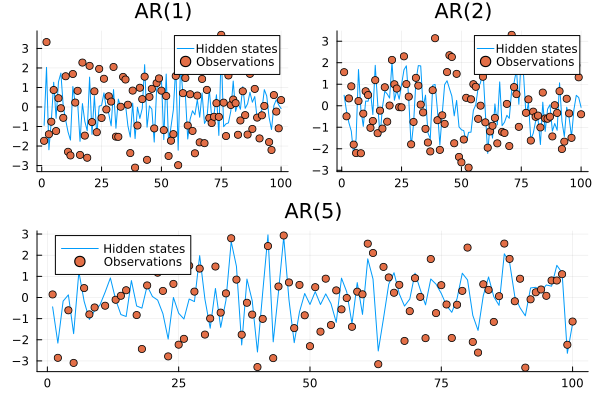

In [109]:
dataset_1 = generate_synthetic_dataset(n = 100, θ = coefs_ar_1)
dataset_2 = generate_synthetic_dataset(n = 100, θ = coefs_ar_2)
dataset_5 = generate_synthetic_dataset(n = 100, θ = coefs_ar_5)

p1 = plot_synthetic_dataset(dataset = dataset_1, title = "AR(1)")
p2 = plot_synthetic_dataset(dataset = dataset_2, title = "AR(2)")
p3 = plot_synthetic_dataset(dataset = dataset_5, title = "AR(5)")

plot(p1, p2, p3, layout = @layout([ a b ; c ]))

## Model Specification: Translating Theory to Code

With our synthetic data ready, we now tackle the critical step of encoding our autoregressive model as a probabilistic program in RxInfer. This translation from mathematical notation to executable code is where the power of probabilistic programming truly shines.

In [269]:
@model function lar_multivariate(y, order, γ)
    # `c` is a unit vector of size `order` with first element equal to 1
    c = ReactiveMP.ar_unit(Multivariate, order)
    
    τ  ~ Gamma(α = 1.0, β = 1.0)
    θ  ~ MvNormal(mean = zeros(order), precision = diageye(order))
    x0 ~ MvNormal(mean = zeros(order), precision = diageye(order))
    
    x_prev = x0
    
    for i in eachindex(y)
 
        x[i] ~ AR(x_prev, θ, τ) 
        y[i] ~ Normal(mean = dot(c, x[i]), precision = γ)
        
        x_prev = x[i]
    end
end

### Constraints specification

Bayesian inference for complex models often requires approximations. Our code uses variational inference with a specific factorization constraint:

In [270]:
@constraints function ar_constraints() 
    q(x0, x, θ, τ) = q(x0, x)q(θ)q(τ)
end

ar_constraints (generic function with 1 method)

This constraint defines how we'll approximate the joint posterior:
- We factorize it into three independent components
- States `(x0, x)` remain jointly distributed, preserving temporal dependencies
- Model parameters `(θ, τ)` are separated from states and each other
- Each component can be updated independently during inference

This factorization balances statistical accuracy with computational efficiency and allows RxInfer to apply efficient message-passing algorithms while maintaining the most important dependencies in the model.

### Meta specification

The @meta block in RxInfer provides essential configuration information to specific nodes in your probabilistic model. In short, it tells RxInfer how to customize inference algorithms, what approximation methods to use, and allows to specify extra computational parameters for custom complex factor nodes. 

In [271]:
@meta function ar_meta(order)
    AR() -> ARMeta(Multivariate, order, ARsafe())
end

ar_meta (generic function with 1 method)

For autoregressive models, this block tells RxInfer:

- Which type of AR process to use (Univariate/Multivariate)
- The order of the process (how many past values influence the current one)
- Any stability constraints to apply during inference

For more information about specific arguments refer to the `AR` node documentation.
For more information on meta blocks, see the [RxInfer.jl documentation](https://docs.rxinfer.ml/stable/manuals/meta-specification/).


### Initialization specification

The @initialization block in RxInfer specifies the initial marginal distributions for the model parameters. This is crucial for the convergence of inference algorithms, especially for complex models like autoregressive processes.

For our autoregressive models, we initialize:

In [272]:
@initialization function ar_init(order)
    q(τ) = GammaShapeRate(1.0, 1.0)
    q(θ) = MvNormalMeanPrecision(zeros(order), diageye(order))
end

ar_init (generic function with 1 method)

### Inference

With our model defined, constraints established, and meta configurations in place, we're now at the exciting moment of truth - running Bayesian inference on our latent autoregressive model!

In [273]:
real_θ = coefs_ar_5
real_τ = 0.5
real_γ = 2.0

order = length(real_θ)
n     = 500 

states, observations = generate_synthetic_dataset(n = n, θ = real_θ, τ = real_τ, γ = real_γ)

result = infer(
    model          = lar_multivariate(order = order, γ = real_γ), 
    data           = (y = observations, ),
    constraints    = ar_constraints(),
    meta           = ar_meta(order),
    initialization = ar_init(order),
    options        = (limit_stack_depth = 500, ),
    returnvars     = (x = KeepLast(), τ = KeepEach(), θ = KeepEach()),
    free_energy    = true,
    iterations     = 20
)

Inference results:
  Posteriors       | available for (τ, θ, x)
  Free Energy:     | Real[1575.77, 1261.1, 1056.63, 1011.25, 1001.28, 997.491, 995.92, 995.375, 995.066, 994.961, 994.913, 994.833, 994.899, 994.864, 994.834, 994.894, 994.872, 994.88, 994.897, 994.913]


Now that our inference procedure has completed, we've obtained posterior distributions for all our model parameters and latent states. The AR coefficients, precision parameters, and hidden state sequence have all been inferred from the data, with complete uncertainty quantification.

But numbers alone don't tell the full story. Let's visualize these results to better understand what our model has captured. By plotting the inferred latent states against our observations, we can see how well our model has filtered out the noise to reveal the underlying process dynamics.

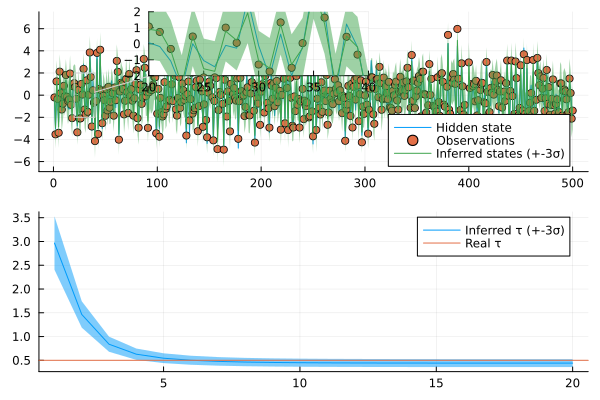

In [274]:
posterior_states       = result.posteriors[:x]
posterior_τ            = result.posteriors[:τ]

p1 = plot(first.(states), label="Hidden state")
p1 = scatter!(p1, observations, label="Observations")
p1 = plot!(p1, first.(mean.(posterior_states)), ribbon = 3first.(std.(posterior_states)), label="Inferred states (+-3σ)", legend = :bottomright)
p1 = lens!(p1, [20, 40], [-2, 2], inset = (1, bbox(0.2, 0.0, 0.4, 0.4)))

p2 = plot(mean.(posterior_τ), ribbon = 3std.(posterior_τ), label = "Inferred τ (+-3σ)", legend = :topright)
p2 = plot!([ real_τ ], seriestype = :hline, label = "Real τ")


plot(p1, p2, layout = @layout([ a; b ]))

When performing variational inference in RxInfer, the Bethe Free Energy (BFE) graph is a crucial diagnostic tool that reveals the convergence properties of our inference algorithm.

The Bethe Free Energy represents the objective function being minimized during variational inference. On the graph:
- The vertical axis shows the BFE value (lower is better)
- The horizontal axis shows iteration number
- The downward slope indicates the algorithm is improving its approximation
- A plateau signals convergence - the point where additional iterations yield minimal improvement

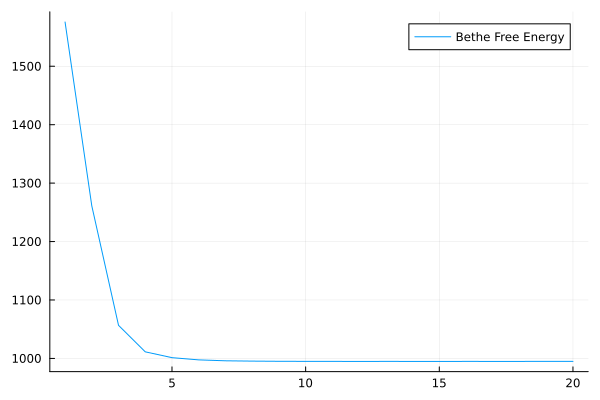

In [275]:
plot(result.free_energy, label = "Bethe Free Energy")

For autoregressive models specifically, the BFE graph helps us:
- Confirm convergence: Ensuring our parameter and state estimates are reliable
- Detect inference challenges: Slow convergence may indicate model misspecification
- Compare models: Different AR orders or constraints can be compared by their final BFE values

A sharply decreasing curve that quickly plateaus suggests efficient, successful inference In contrast, a slowly decreasing or unstable curve might indicate challenges with our model specification or data characteristics.

It is also interesting to see where our AR coefficients converge to:

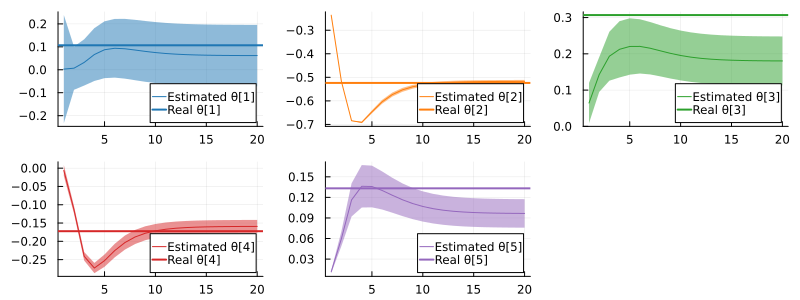

In [278]:
posterior_coefficients = result.posteriors[:θ]

pθ = []
cθ = Plots.palette(:tab10)

θms = mean.(posterior_coefficients)
θvs = 3std.(posterior_coefficients)

for i in 1:length(first(θms))
    push!(pθ, plot(getindex.(θms, i), ribbon = getindex.(θvs, i), label = "Estimated θ[$i]", color = cθ[i]))
end

for i in 1:length(real_θ)
    plot!(pθ[i], [ real_θ[i] ], seriestype = :hline, label = "Real θ[$i]", color = cθ[i], linewidth = 2)
end

plot(pθ..., size = (800, 300), legend = :bottomright)

# Autoregressive Moving Average Model

Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be effectively implemeted in **RxInfer.jl**. For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432). 
The Bayesian ARMA model can be written as follows:


$$\begin{aligned}
e_t \sim \mathcal{N}(0, \gamma^{-1}) \quad
\theta &\sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \quad
\eta \sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \\
\mathbf{h}_0 &\sim \mathcal{MN}\left(\begin{bmatrix}
e_{-1} \\
e_{-2}
\end{bmatrix}, \mathbf{I}\right) \\
\mathbf{h}_t &= \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1} \\
\mathbf{x}_t &= \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t 
\end{aligned}$$

where shift matrix $\mathbf{S}$ is

$$\begin{aligned}
\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}
\end{aligned}$$

and unit vector $\mathbf{c}$: 

$$\begin{aligned}
\mathbf{c}=[1, 0]
\end{aligned}$$ 

when MA order is $2$

In this way, $\mathbf{h}_t$ containing errors $e_t$ can be viewed as hidden state.

In short, the Bayesian ARMA model has two intractabilities: (1) induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, (2) induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop). Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

In [19]:
# Load packages
using RxInfer, LinearAlgebra, CSV, DataFrames, Plots

In [20]:
# Define shift function
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [21]:
@model function ARMA(x, x_prev, h_prior, γ_prior, τ_prior, η_prior, θ_prior, c, b, S)
    
    # priors
    γ  ~ γ_prior
    η  ~ η_prior
    θ  ~ θ_prior
    τ  ~ τ_prior
    
    # initial
    h_0 ~ h_prior
    z[1] ~ AR(h_0, η, τ)
    e[1] ~ Normal(mean = 0.0, precision = γ)

    x[1] ~ dot(b, z[1]) + dot(θ, x_prev[1]) + e[1]
    
    h_prev = h_0
    for t in 1:length(x)-1
        
        e[t+1] ~ Normal(mean = 0.0, precision = γ)
        h[t]   ~ S*h_prev + b*e[t]
        z[t+1] ~ AR(h[t], η, τ)
        x[t+1] ~ dot(z[t+1], b) + dot(θ, x_prev[t]) + e[t+1]
        h_prev = h[t]
    end
end

To validate our model and inference, we will use American Airlines stock data downloaded from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

In [22]:
x_df = CSV.read("aal_stock.csv", DataFrame)

Row,date,open,high,low,close,volume,Name
,Date,Float64,Float64,Float64,Float64,Int64,String3
1,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
3,2013-02-12,14.45,14.51,14.1,14.27,8126000,AAL
4,2013-02-13,14.3,14.94,14.25,14.66,10259500,AAL
5,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
6,2013-02-15,13.93,14.61,13.93,14.5,15628000,AAL
7,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
8,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
9,2013-02-21,13.62,13.95,12.9,13.37,11922100,AAL


In [23]:
# we will use "close" column
x_data = filter(!ismissing, x_df[:, 5]);

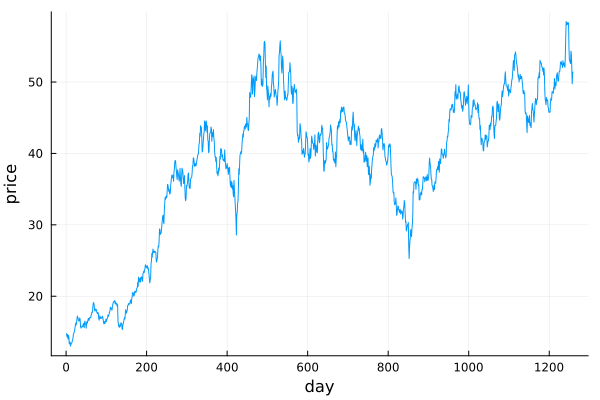

In [24]:
# Plot data
plot(x_data, xlabel="day", ylabel="price", label=false)

In [25]:
p_order = 10 # AR
q_order = 4 # MA

4

In [26]:
# Training set
train_size = 1000
x_prev_train = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:train_size]
x_train = Float64.(x_data[p_order+1:end])[1:train_size];

In [27]:
# Test set
x_prev_test = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][train_size+1:end]
x_test = Float64.(x_data[p_order+1:end])[train_size+1:end];

### Inference

In [28]:
# Constraints are needed for performing VMP
arma_constraints = @constraints begin
    q(z, h_0, h, η, τ, γ,e) = q(h_0)q(z, h)q(η)q(τ)q(γ)q(e)
end;

In [29]:
# This cell defines prior knowledge for model parameters
h_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
γ_prior = GammaShapeRate(1e4, 1.0)
τ_prior = GammaShapeRate(1e2, 1.0)
η_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
θ_prior = MvNormalMeanPrecision(zeros(p_order), diageye(p_order));

In [30]:
# Model's graph has structural loops, hence, it requires pre-initialisation
arma_initialization = @initialization begin
    q(h_0) = h_prior
    μ(h_0) = h_prior
    q(h) = h_prior
    μ(h) = h_prior
    q(γ) = γ_prior
    q(τ) = τ_prior
    q(η) = η_prior
    q(θ) = θ_prior

end
arma_meta       = ar_meta(Multivariate, q_order, ARsafe());

In [31]:
c = zeros(p_order); c[1] = 1.0; # AR
b = zeros(q_order); b[1] = 1.0; # MA
S = shift(q_order); # MA


result = infer(
    model = ARMA(x_prev=x_prev_train, h_prior=h_prior, γ_prior=γ_prior, τ_prior=τ_prior, η_prior=η_prior, θ_prior=θ_prior, c=c, b=b, S=S), 
    data  = (x = x_train, ),
    initialization = arma_initialization,
    constraints   = arma_constraints,
    meta          = arma_meta,
    iterations    = 10,
    options       = (limit_stack_depth = 400, ),
);

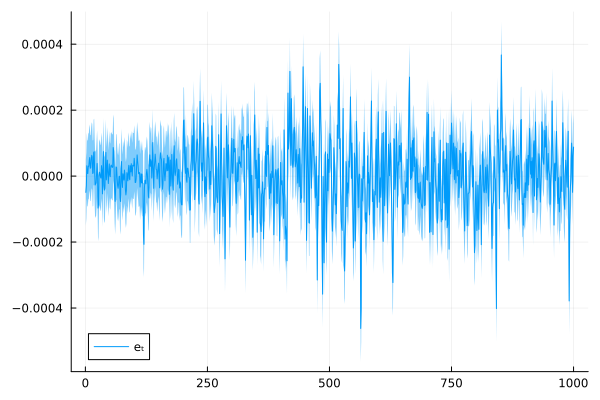

In [32]:
plot(mean.(result.posteriors[:e][end]), ribbon = var.(result.posteriors[:e][end]), label = "eₜ")

In [33]:
# extract posteriors
h_posterior = result.posteriors[:h][end][end]
γ_posterior = result.posteriors[:γ][end]
τ_posterior = result.posteriors[:τ][end]
η_posterior = result.posteriors[:η][end]
θ_posterior = result.posteriors[:θ][end];

## Prediction

Here we are going to use our inference results in order to predict the dataset itself

In [34]:
# The prediction function is aimed at approximating the predictive posterior distribution
# It triggers the rules in the generative order (in future, RxInfer.jl will provide this function out of the box)
function prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p, q)
    h_out = MvNormalMeanPrecision(mean(h_posterior), precision(h_posterior))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=h_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, p, ARsafe()))
    c = zeros(p); c[1] = 1.0
    b = zeros(q); b[1] = 1.0
    ar_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(b), m_in2=ar_out)
    θ_out = MvNormalMeanPrecision(mean(θ_posterior), precision(θ_posterior))
    ma_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(x_prev), m_in2=θ_out)
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=PointMass(0.0), q_τ=mean(γ_posterior))
    ar_ma = @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_dot_out, m_in2=ma_dot_out)  
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_ma, m_in2=e_out)  
end

prediction (generic function with 1 method)

In [35]:
predictions = []
for x_prev in x_prev_test
    push!(predictions, prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p_order, q_order))
    # after every new prediction we can actually "retrain" the model to use the power of Bayesian approach
    # we will skip this part at this notebook
end

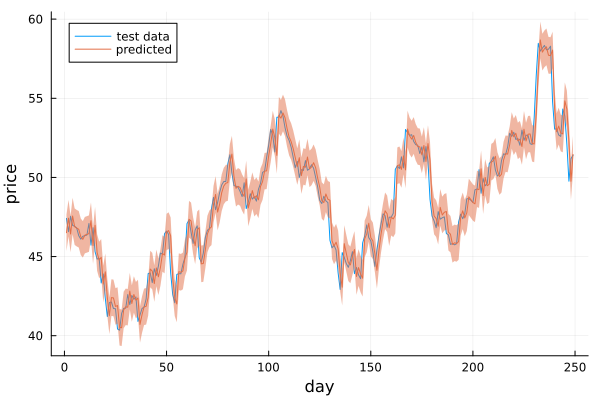

In [36]:
plot(x_test, label="test data", legend=:topleft)
plot!(mean.(predictions)[1:end], ribbon=std.(predictions)[1:end], label="predicted", xlabel="day", ylabel="price")